https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://towardsdatascience.com/andwritten-digit-mnist-pytorch-977b5338e627

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import numpy as np
import random

## Hyperparameters

In [13]:
# hyperparameters
batch_size = 4
epochs = 5
n_workers = 0

## Loading data

In [14]:
# Loading the MNIST dataset. Normalizing image values between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)


# Loading data to dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=n_workers)



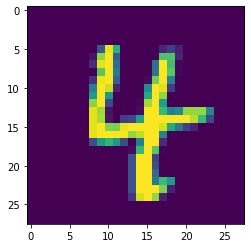

label:4


In [15]:
# Showing image example
def show_img(img):
    img = img/2 +0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

random_idx =  random.randint(0, len(trainset))
image, label = trainset[random_idx]
show_img(image)
print(f'label:{label}')

In [16]:
print('max value: ', trainset[random_idx][0].max())
print('min value: ', trainset[random_idx][0].min())

max value:  tensor(1.)
min value:  tensor(-1.)


In [17]:
# Explore shape of data
X_train, y_train = next(iter(trainloader))
print(X_train.shape, y_train.shape)
# # print the class of the image
# print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

torch.Size([4, 1, 28, 28]) torch.Size([4])


## Preparing data

In [18]:
# Categorically encoding the label

In [19]:
y_train

tensor([0, 7, 1, 1])

## Create model

In [20]:

class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

model= Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [21]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

## Training the model

In [23]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    final_loss = 0.0
    for i, data in enumerate(trainloader):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            train_acc = get_accuracy(labels, pred_labels)
            print(f'Step [{i+1}/{len(trainloader)}]: Loss = {loss.item()} - Accuracy = {train_acc}')

        # save loss
        final_loss +=loss.item()



In [25]:
# Saving model
model_saving_p = './mnist_net.pth'
torch.save(model.state_dict(), model_saving_p)

## Testing the model


In [26]:
model.load_state_dict(torch.load(model_saving_p))

total = 0
correct = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, pred_labels = torch.max(outputs.data, 1)
        total+= 1#labels.size(0)
        correct+= get_accuracy(labels, pred_labels)
        
        # print(f'correct / total: {correct} / {total}')
print(f'Accuracy on the test set: {correct / total}')
